# Sec Recon Network Visualization
This notebook is for the visualization of the Secretory Pathway Reconstruction. Here we try different approaches  the visualization. First, we generate a python dictionary with all the necessary information that will be used for downstream analysys. The first analysis is bases on a dimensionality reduction of the data set for UMAP plotting of the genes. In the second analysis we generate a network of the Sec Recon in which all the nodes represent genes interconnected by the processes they share.

In [1]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Circle
from scipy.spatial import ConvexHull

from itertools import combinations
from utils import integrate_dicts, get_gene_color, flatten_processes, adjust_color_alpha, categorize_location

## 1 Generate a "gene_dict" dictionary with all the necessary information stored into it

In [2]:
# Generate secrecon dataframe
secrecon = pd.read_csv("Input/masterTable.csv")
unprocesses = pd.read_excel("Input/uniqueProcesses_finalOntology.xlsx", sheet_name="Final ontology")
complexes = pd.read_csv("Input/Complexes.csv")
cho2human_mapping = pd.read_csv("cho2human_mapping.tsv", sep='\t')
subcell = pd.read_csv("Input/subcellular_localization.csv")

In [3]:
subcell_dict = dict(zip(subcell['Gene_name_canonical'], subcell['consensus graph-based annotation (this study)']))

In [4]:
# Standarization of the subcellular compartments to be merged with the compartments in the Sec Recon dataset

for key in subcell_dict:
    if subcell_dict[key] == 'early_endosome':
        subcell_dict[key] = list(['Early Endosome'])
    elif subcell_dict[key] == 'centrosome':
        subcell_dict[key] = list(['Centrosome'])
    elif subcell_dict[key] == 'ER':
        subcell_dict[key] = list(['Endoplasmic Reticulum'])
    elif subcell_dict[key] == 'mitochondrion':
        subcell_dict[key] = list(['Mitochondria'])
    elif subcell_dict[key] == 'stress_granule':
        subcell_dict[key] = list(['Stress Granule'])
    elif subcell_dict[key] == 'unclassified':
        subcell_dict[key] = None
    elif subcell_dict[key] == 'peroxisome':
        subcell_dict[key] = list(['Peroxisome'])
    elif subcell_dict[key] == '14-3-3_scaffold':
        subcell_dict[key] = None
    elif subcell_dict[key] == 'recycling_endosome':
        subcell_dict[key] = list(['Recycling Endosome'])
    elif subcell_dict[key] == 'plasma_membrane':
        subcell_dict[key] = list(['Plasma Membrane'])
    elif subcell_dict[key] == 'lysosome':
        subcell_dict[key] = list(['Lysosome'])
    elif subcell_dict[key] == 'translation':
        subcell_dict[key] = list(['Translation'])
    elif subcell_dict[key] == 'actin_cytoskeleton':
        subcell_dict[key] = list(['Actin Cytoskeleton'])
    elif subcell_dict[key] == 'cytosol':
        subcell_dict[key] = list(['Cytoplasm'])
    elif subcell_dict[key] == 'nucleus':
        subcell_dict[key] = list(['Nucleus'])
    elif subcell_dict[key] == 'ERGIC':
        subcell_dict[key] = list(['ERGIC'])
    elif subcell_dict[key] == 'p-body':
        subcell_dict[key] = list(['P-Body'])
    elif subcell_dict[key] == 'trans-Golgi':
        subcell_dict[key] = list(['trans-Golgi'])
    elif subcell_dict[key] == 'nucleolus':
        subcell_dict[key] = list(['Nucleolus'])
    elif subcell_dict[key] == 'proteasome':
        subcell_dict[key] = list(['Proteasome'])
    elif subcell_dict[key] == 'Golgi':
        subcell_dict[key] = list(['Golgi'])

In [5]:
# Map CHO IDs to Human IDs to fill in blank spaces
counter = 0
cho_id_lookup = dict(zip(cho2human_mapping['HUMAN_ID'], cho2human_mapping['CHO_ID']))

for index, row in secrecon.iterrows():
    if pd.isna(row['CHO_ENTREZID']) or row['CHO_ENTREZID'] == '':
        human_id = row['ENTREZID']
        cho_id = cho_id_lookup.get(human_id)
        counter += 1
        if cho_id is not None:
            secrecon.at[index, 'CHO_ENTREZID'] = cho_id

In [6]:
# Trim the information if the Subcellular localization column in order to keep just the compartment name
secrecon['Subcellular location [CC]'] = secrecon['Subcellular location [CC]'].apply(categorize_location)
secrecon['Subcellular_location_2'] = secrecon['SYMBOL'].map(subcell_dict)

In [7]:
#Generate dictionaries

# Process Dict
process_dict = {}

for index, row in unprocesses.iterrows():
    system = row['System']
    subsystem = row['Subsystem'] if pd.notna(row['Subsystem']) else None
    process = row['Process'] if pd.notna(row['Process']) else None
    subprocess = row['Subprocess'] if pd.notna(row['Subprocess']) else None
    
    if system not in process_dict:
        process_dict[system] = []
        
    process_dict[system].append({k: v for k, v in {
        'Subsystem': subsystem,
        'Process': process,
        'Subprocess': subprocess
    }.items() if v is not None})

gene_dict = {}
for index, row in secrecon.iterrows():
    gene = row['SYMBOL']
    # Grab the processes and filter out any NaN values
    # Add the subcellular localizations
    processes = row[['Process.1', 'Process.2', 'Process.3', 'Process.4', 'Process.5',
                     'Process.6', 'Process.7', 'Process.8', 'Process.9', 'Process.10']].dropna().tolist()
    if pd.isna(row['Subcellular_location_2']):
        localization = row['Subcellular location [CC]']
    else:
        localization = row['Subcellular_location_2']
    
    gene_dict[gene] = {'processes': processes, 'subcellular_localization': localization}
    

#Complexes dict

# Pre-select all the complexes in Human
complexes = complexes[complexes['Organism'] == 'Human']
gene_complex_dict = {}

for index, row in complexes.iterrows():
    gene_symbol = row['SYMBOL']
    complex_name = row['ComplexName']
    # Check if the gene symbol is already a key in the dictionary
    if gene_symbol in gene_complex_dict:
        # Append the complex name to the existing list
        gene_complex_dict[gene_symbol].append(complex_name)
    else:
        # Create a new key with the complex name as the first item in the list
        gene_complex_dict[gene_symbol] = [complex_name]

In [8]:
# Integrate gene_dict with info from the "process_dict"
gene_dict = integrate_dicts(gene_dict, process_dict)

In [9]:
# Add the complexes to the gene_dict. If a gene is not part of any complex, we will put 'Not part of any complex'
for gene in gene_dict:
    gene_dict[gene]['complex'] = gene_complex_dict.get(gene)#, 'Not part of any complex')

In [10]:
# Genes with no subcellular localization
count = 0
for key in gene_dict:
    if gene_dict[key]['subcellular_localization'] == []:
        print(key,gene_dict[key]['subcellular_localization'])
        count += 1
        
print(count)

ACAP3 []
ALG1L []
ALG1L2 []
ARAF []
ARPC1B []
B3GNTL1 []
BAG2 []
CUL1 []
DDI1 []
DNAJC6 []
FBXO8 []
GCNT4 []
GLT1D1 []
GPLD1 []
HSP90AA5P []
HSP90AB3P []
HSP90AB4P []
HSPA12B []
HSPA1L []
MICALCL []
PIK3CA []
PSMD4 []
PSMD5 []
RAB44 []
SEC1P []
SEC22C []
TBC1D10C []
TBC1D22B []
TBC1D9 []
TMED6 []
TRAPPC3L []
UBA7 []
UBE2D2 []
UBE2D4 []
UBQLN3 []
UBQLNL []
UBXN2A []
WDR38 []
38


In [11]:
with open('gene_dict.pkl', 'wb') as f:
    pickle.dump(gene_dict, f)

In [12]:
with open('process_dict.pkl', 'wb') as f:
    pickle.dump(process_dict, f)

## 2 Dimensionality reduction / one hot encoding for UMAP visualization

In [ ]:
from sklearn.neighbors import NearestNeighbors
import umap
import igraph as ig
import leidenalg as la
import seaborn as sns
import networkx as nx

In [ ]:
# One hot encoding

# Flatten the dictionary
flattened_data = []
for gene, attributes in gene_dict.items():
    for key, values in attributes.items():
        if key == 'subcellular_localization':  # Skip this subkey
            continue
        if values is None:
            continue
        if not isinstance(values, list):
            values = [values]
        for value in values:
            # Tag each attribute
            attribute_tag = f"{key}_{value}"
            flattened_data.append({'gene': gene, 'attribute_tag': attribute_tag, 'attribute_value': value, 'attribute_type': key})

# Create a DataFrame
df = pd.DataFrame(flattened_data)
one_hot_encoded_df = pd.get_dummies(df, columns=['attribute_value'], prefix='', prefix_sep='')

# Assign higher values to 'complex' attributes
complex_multiplier = 2  # Define your multiplier for 'complex' attributes
for index, row in df.iterrows():
    if row['attribute_type'] == 'complex':
        for column in one_hot_encoded_df.columns:
            if column in row['attribute_tag']:
                one_hot_encoded_df.at[index, column] *= complex_multiplier

# Group by 'gene'
final_encoded_df = one_hot_encoded_df.groupby('gene').sum().reset_index()


final_encoded_df

In [ ]:
# Prepare the data (excluding the gene column for the KNN input)
X = final_encoded_df.drop('gene', axis=1)

# Consistent distance metric
distance_metric = 'euclidean'  # Choose 'euclidean', 'cosine', etc.

In [ ]:
# Initialize the KNN model with consistent n_neighbors
n_neighbors = 20  # Adjust as needed
knn = NearestNeighbors(n_neighbors=n_neighbors, metric=distance_metric)
knn.fit(X)
distances, indices = knn.kneighbors(X)

In [ ]:
# Apply UMAP with consistent parameters
reducer = umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=0.01,  # Adjust as needed
    n_components=2,
    spread=40,  # Adjust as needed
    random_state=42,
    metric=distance_metric
)
embedding = reducer.fit_transform(X)

In [ ]:
# Create a Graph for Leiden Algorithm
G = nx.Graph()
for idx, neighbors in enumerate(indices):
    for neighbor in neighbors:
        G.add_edge(idx, neighbor)

# Convert to iGraph
ig_graph = ig.Graph.from_networkx(G)

# Apply Leiden Algorithm with adjustable resolution
resolution_parameter = 1.4
partition = la.find_partition(ig_graph, la.RBConfigurationVertexPartition, 
                              resolution_parameter=resolution_parameter)

# Visualize UMAP with Leiden Clusters
plt.figure(figsize=(12, 8))
cluster_membership = np.array(partition.membership)

# Find unique clusters
unique_clusters = np.unique(cluster_membership)

# Create a color map
colors = plt.cm.get_cmap('viridis', len(unique_clusters))

# Plot each cluster with its specific color
for cluster_id in unique_clusters:
    plt.scatter(
        embedding[cluster_membership == cluster_id, 0],
        embedding[cluster_membership == cluster_id, 1],
        color=colors(cluster_id),
        label=f'Cluster {cluster_id}',
        s=40,  # Adjust point size
        alpha=0.8  # Adjust transparency
    )

plt.title('UMAP Projection with Leiden Clustering')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title='Cluster ID')  # Add a legend
plt.savefig('umap_leiden_clusters.png', dpi=300)
plt.show()

In [ ]:
localization_colors = {
    'Actin Cytoskeleton': (0.7, 0.4, 0.2, 1.0),
    'Centrosome': (0.0, 0.5, 0.5, 1.0),
    'ERGIC': (1.0, 0.6, 0.0, 1.0),
    'Endosome': (0.0, 0.7, 0.3, 1.0), 
    'Recycling Endosome': (0.3, 0.0, 0.7, 1.0), 
    'Early Endosome': (0.7, 0.0, 0.4, 1.0), 
    'Plasma Membrane': (0.5, 0.5, 0.0, 1.0), 
    'Golgi': (0.1, 0.9, 0.1, 1.0), 
    'cis-Golgi': (0.2, 0.8, 0.6, 1.0),
    'trans-Golgi': (0.4, 0.8, 0.4, 1.0), 
    'Nucleus': (0.9, 0.1, 0.1, 1.0),
    'Nucleolus': (0.5, 0.1, 0.1, 1.0),
    'Phagosome': (0.6, 0.3, 0.0, 1.0),
    'Proteasome': (0.3, 0.3, 0.9, 1.0),
    'Mitochondria': (0.9, 0.5, 0.5, 1.0),
    'Lysosome': (0.5, 0.9, 0.8, 1.0),  
    'Cytoplasm': (0.4, 0.7, 0.9, 1.0),
    'Endoplasmic Reticulum': (0.7, 0.7, 0.3, 1.0),
    'Stress Granule': (0.8, 0.4, 0.0, 1.0),
    'Translation': (0.8, 0.2, 0.8, 1.0)
}

# Extract subcellular localization for each gene
subcellular_localization_df = pd.DataFrame(
    [(gene, locs[0]) for gene, attrs in gene_dict.items() for locs in [attrs.get('subcellular_localization', [''])] if locs],
    columns=['gene', 'subcellular_localization'])


# Convert UMAP embedding to a DataFrame
embedding_df = pd.DataFrame(embedding, columns=['UMAP_1', 'UMAP_2'])

# Add a 'gene' column from your original DataFrame for alignment
embedding_df['gene'] = final_encoded_df['gene'].values

# Merge the UMAP results with subcellular localization
umap_localization_df = pd.merge(embedding_df, subcellular_localization_df, on='gene')

# Now plot with color coding
plt.figure(figsize=(40, 40))
for loc, color in localization_colors.items():
    # Find the subset of the data frame that corresponds to the current localization
    subset = umap_localization_df[umap_localization_df['subcellular_localization'] == loc]
    # Plot this subset with the predefined color
    plt.scatter(subset['UMAP_1'], subset['UMAP_2'], label=loc, color=color, s=550, alpha=0.5)

plt.legend(prop={'size': 25}, loc='lower left', bbox_to_anchor=(0.77, 0.65))
plt.subplots_adjust(right=0.75)

plt.title('2D UMAP Projection Colored by Subcellular Localization')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

## 3. Network Visualization

In [13]:
from math import sqrt, ceil
import networkx as nx

In [14]:
localization_colors = {
    'Actin Cytoskeleton': (0.7, 0.4, 0.2, 1.0),
    'Centrosome': (0.0, 0.5, 0.5, 1.0),
    'ERGIC': (1.0, 0.6, 0.0, 1.0),
    'Endosome': (0.0, 0.7, 0.3, 1.0), 
    'Recycling Endosome': (0.3, 0.0, 0.7, 1.0), 
    'Early Endosome': (0.7, 0.0, 0.4, 1.0), 
    'Plasma Membrane': (0.5, 0.5, 0.0, 1.0), 
    'Golgi': (0.1, 0.9, 0.1, 1.0), 
    'cis-Golgi': (0.2, 0.8, 0.6, 1.0),
    'trans-Golgi': (0.4, 0.8, 0.4, 1.0), 
    'Nucleus': (0.9, 0.1, 0.1, 1.0),
    'Nucleolus': (0.5, 0.1, 0.1, 1.0),
    'Phagosome': (0.6, 0.3, 0.0, 1.0),
    'Proteasome': (0.3, 0.3, 0.9, 1.0),
    'Mitochondria': (0.9, 0.5, 0.5, 1.0),
    'Lysosome': (0.5, 0.9, 0.8, 1.0),  
    'Cytoplasm': (0.4, 0.7, 0.9, 1.0),
    'Endoplasmic Reticulum': (0.7, 0.7, 0.3, 1.0),
    'Stress Granule': (0.8, 0.4, 0.0, 1.0),
    'Translation': (0.8, 0.2, 0.8, 1.0)
}

### 3.1 Generate the network

In [19]:
# Build the network
G = nx.Graph()

# Adding nodes
for gene in gene_dict:
    G.add_node(gene)

# Constants for edge weights
PROCESSES_WEIGHT = 1
PROCESS_WEIGHT = 0.5
SUBSYSTEM_WEIGHT = 0.25
SYSTEM_WEIGHT = 0.125
COMPLEX_WEIGHT = 2

# Add edges to the nodes
for gene1, gene2 in combinations(gene_dict.keys(), 2):  # 2 for pairs
    # Calculate shared processes
    shared_processes = len(set(gene_dict[gene1]['processes']).intersection(gene_dict[gene2]['processes']))
    # Calculate shared process: this may seem redundant but genes with subprocesses have proceeses as a parent category
    if gene_dict[gene1]['process'] is None or gene_dict[gene2]['process'] is None:
        shared_process = 0
    else:
        shared_process = len(set(gene_dict[gene1]['process']).intersection(gene_dict[gene2]['process']))
    # Calculate shared subsystem
    if gene_dict[gene1]['subsystem'] is None or gene_dict[gene2]['subsystem'] is None:
        shared_subsystem = 0
    else:
        shared_subsystem = len(set(gene_dict[gene1]['subsystem']).intersection(gene_dict[gene2]['subsystem']))
    # Calculate shared system
    if gene_dict[gene1]['system'] is None or gene_dict[gene2]['system'] is None:
        shared_system = 0
    else:
        shared_system = len(set(gene_dict[gene1]['system']).intersection(gene_dict[gene2]['system']))
    # Check for shared complex
    if gene_dict[gene1]['complex'] is None or gene_dict[gene2]['complex'] is None:
        shared_complex = 0
    else:
        shared_complex = len(set(gene_dict[gene1]['complex'] or []).intersection(gene_dict[gene2]['complex'] or []))
        
    shared_processes = shared_processes*PROCESSES_WEIGHT
    shared_process = shared_process*PROCESS_WEIGHT
    shared_subsystem = shared_subsystem*SUBSYSTEM_WEIGHT
    shared_system = shared_system*SYSTEM_WEIGHT
    shared_complex = shared_complex*COMPLEX_WEIGHT
    edge_weight = shared_processes + shared_process + shared_subsystem + shared_system + shared_complex
    G.add_edge(gene1, gene2, weight=edge_weight)
    

# Draw the graph layout
pos = nx.spring_layout(G, seed=42, iterations=60, k=0.6)

### 3.2 Reorganize nodes at the edge

In [20]:
# Initialize a dictionary to track the highest weight for each node
highest_weight = {}

# Iterate over all edges to update the highest weight for each node
for u, v, data in G.edges(data=True):
    weight = data['weight']
    # Update the highest weight for nodes u and v
    if u not in highest_weight or highest_weight[u] < weight:
        highest_weight[u] = weight
    if v not in highest_weight or highest_weight[v] < weight:
        highest_weight[v] = weight

# Initialize the set of low_weight_nodes
low_weight_nodes = set()
# Add nodes to the set if their highest weight is below 1
for node, weight in highest_weight.items():
    if weight < 1:
        low_weight_nodes.add(node)
        
# Calculate layout bounds to help define the rectangle area
x_values, y_values = zip(*pos.values())
plot_width = max(x_values) - min(x_values)
plot_height = max(y_values) - min(y_values)

# Define the rectangle's bottom right corner and dimensions
rect_width = plot_width * 0.15  # 15% of the plot width
rect_height = plot_height * 0.15  # 15% of the plot height
rect_bottom_right_x = max(x_values)
rect_bottom_right_y = min(y_values)

# Calculate layout bounds to help define the rectangle area
x_values, y_values = zip(*pos.values())
min_x_val, max_x_val = min(x_values), max(x_values)  
min_y_val, max_y_val = min(y_values), max(y_values)

# Calculate the number of low-weight edge nodes for grid dimension calculation
num_low_weight_nodes = len(low_weight_nodes)
cols = int(round(sqrt(num_low_weight_nodes)))
rows = int(ceil(num_low_weight_nodes / cols))

# Calculate positions within the rectangle for each low-weight edge node
for i, node in enumerate(low_weight_nodes):
    col = i % cols
    row = i // cols
    
    # Calculate grid cell position
    new_x = rect_bottom_right_x - rect_width + (col + 1) * (rect_width / (cols + 1))
    new_y = rect_bottom_right_y + (row + 1) * (rect_height / (rows + 1))
    
    # Update position
    pos[node] = (new_x, new_y)

In [21]:
# Save the network as a GraphML
nx.write_graphml(G, 'Network/sec_recon_network.graphml')

### 3.3 Create the plot

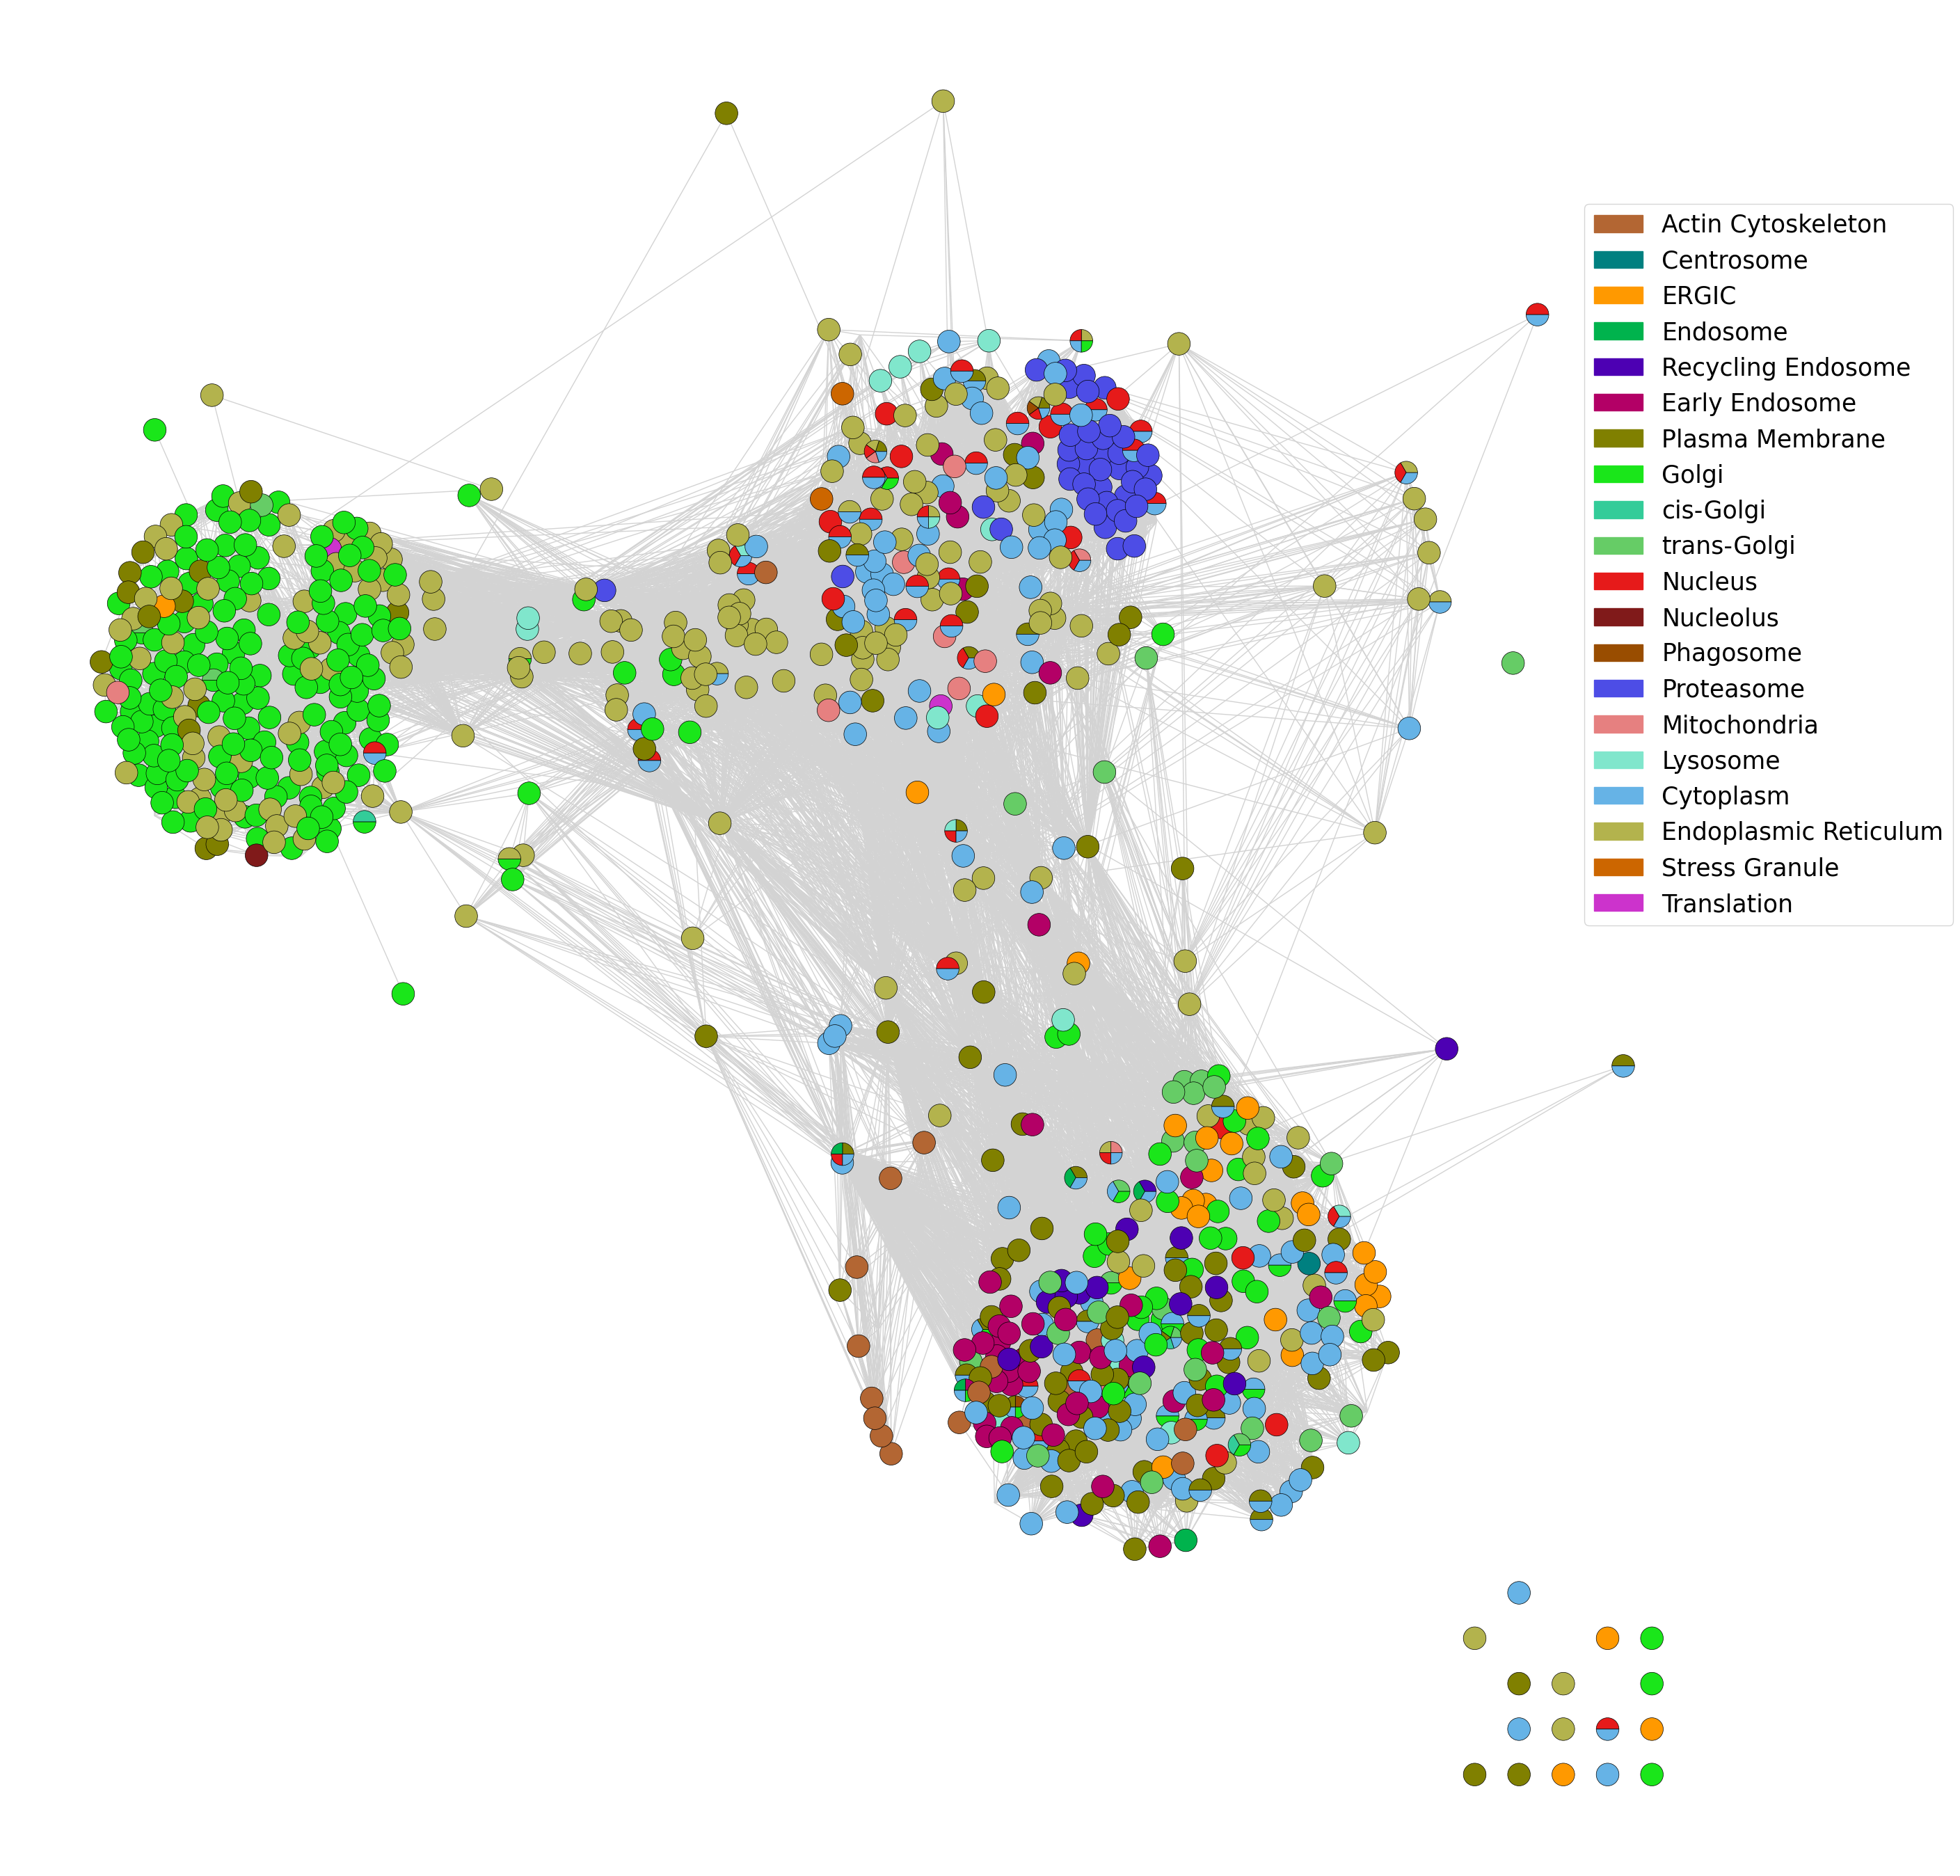

In [23]:
# Initialize the figure and axis
fig, ax = plt.subplots(figsize=(40, 40))

# Only plot edges that are greater than 1 in weight
edgelist = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] >= 1]

# Draw edges
nx.draw_networkx_edges(G, pos, edgelist=edgelist, edge_color='lightgrey')#, 
                       #width=[G[u][v]['weight'] for u, v in G.edges() if 40 > G[u][v]['weight'] > 2])


def adjust_alpha(color, alpha):
    return (color[0], color[1], color[2], alpha)

# Draw nodes as pie charts
for node, (x, y) in pos.items():
    localizations = gene_dict[node]['subcellular_localization']
    
    # Check if the node is part of any complex
    is_in_complex = gene_dict[node]['complex'] != 'Not part of any complex'
    
    # Set alpha value based on whether the node is in a complex
    alpha_value = 1.0 if is_in_complex else 0.5
    
    # Adjust the alpha value of each color
    colors = [adjust_alpha(localization_colors[loc], alpha_value) for loc in localizations]
    
    # Draw pie chart at node position with edgecolor and linewidth
    ax.pie([1]*len(localizations), colors=colors, radius=0.012, center=(x, y), wedgeprops=dict(edgecolor='black', linewidth=0.5))
    
# Get the current axis limits
x_values, y_values = zip(*pos.values())
min_x, max_x = min(x_values), max(x_values)
min_y, max_y = min(y_values), max(y_values)

# Set new axis limits
ax.set_xlim(min_x - 0.1, max_x + 0.1)
ax.set_ylim(min_y - 0.1, max_y + 0.1)

# Legend
legend_patches = [mpatches.Patch(color=color, label=category) for category, color in localization_colors.items()]
plt.legend(handles=legend_patches, prop={'size': 25}, loc='lower left', bbox_to_anchor=(0.9, 0.5))
plt.subplots_adjust(right=0.75)

plt.savefig('Network/secrecon_network_visualization.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()